In [1]:
"""
Created on Thu Sep 14 10:16:59 2023

@author: 51027
"""
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from preprocess import behavioral_embedding_model,text_embedding,preprocess_data
from Data_loader import create_data_loaders
from model import TextDecisionModel
import matplotlib.pyplot as plt
from preprocess import behavioral_embedding,get_embeddings,option_prompt_generate

In [2]:
class CosineContrastiveLoss(nn.Module):
    def __init__(self, margin=0.9):
        super(CosineContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Cosine similarity
        cosine_sim = nn.functional.cosine_similarity(output1, output2)
        
        # For similar pairs: we want the negative of (1 - cosine_sim) to make it closer to 1
        # For dissimilar pairs: we take max(0, cosine_sim - margin) to push them apart until a certain margin
        loss_contrastive = torch.mean(torch.mean((label) * torch.pow(1 - cosine_sim, 2)) +
                                      torch.mean((1-label) * torch.pow(torch.clamp(cosine_sim - self.margin, min=0.0), 2)))
        return loss_contrastive

In [3]:
class FeatureLoss(nn.Module):
    def __init__(self):
        super(FeatureLoss, self).__init__()
        
    
    def forward(self, output1, output2):
        # Standardize each dimension
        # std1 = torch.std(output1, dim=0, keepdim=True) + 1e-8  # Avoid division by zero
        # mean1 = torch.mean(output1, dim=0, keepdim=True)
        # output1 = (output1 - mean1) / std1
        
        # std2 = torch.std(output2, dim=0, keepdim=True) + 1e-8  # Avoid division by zero
        # mean2 = torch.mean(output2, dim=0, keepdim=True)
        # output2 = (output2 - mean2) / std2
        
        feature_loss = torch.square(output1 - output2)
        return feature_loss

In [4]:
c13k_problems = pd.read_json("data/c13k_problems_test.json", orient='index')
behavioral_embeddings = behavioral_embedding_model(c13k_problems)
c13k_problems_prepro = preprocess_data(c13k_problems)
text_problem_embeddings = text_embedding(c13k_problems_prepro,query = 'online')

In [5]:
batch_size= 256
train_dataloader, val_dataloader,test_dataloader = create_data_loaders(text_problem_embeddings, behavioral_embeddings, batch_size=batch_size, test_size = 0.2, contrastive = False, false_scale = 2, scale = 'outcome_scaling')

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = JointEmbedding().to(device)
model = TextDecisionModel().to(device)

In [7]:
# Define the loss, optimizer, etc.
criterion = FeatureLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
num_epochs = 200
# cosine_similarity_threshold = 0.9 # This can be adjusted based on your needs

In [9]:
feature_losses = {f"dim_{i}": [] for i in range(12)}
val_feature_losses = {f"dim_{i}": [] for i in range(12)}
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # true_pairs_similarity = []
    # false_pairs_similarity = []
    # For storing dimensional losses in an epoch
    epoch_dimensional_losses = {f"dim_{i}": [] for i in range(12)}
    val_epoch_dimensional_losses = {f"dim_{i}": [] for i in range(12)}
    
    for batch in train_dataloader:
        text_embeds = batch["text_embedding"].to(device)
        decision_embeds = batch["decision_embedding"].to(device)
        # labels = batch["label"].to(device)

        optimizer.zero_grad()
        # text_outputs, behavioral_outputs = model(text_embeds, decision_embeds)
        
        decision_pred = model(text_embeds)
        #dimensional-wise loss to track the training
        feature_loss = criterion(decision_pred, decision_embeds)
        #MSE loss indeed
        loss = torch.mean(torch.sum(feature_loss, dim=1))
        # loss = criterion(text_outputs, behavioral_outputs,labels)
        loss.backward()
        optimizer.step()
        
        for i in range(12):
            epoch_dimensional_losses[f"dim_{i}"].append(feature_loss[:, i].mean().item())
        
        total_loss += loss.item()
    
    # Store the average dimensional loss for this epoch
    for i in range(12):
        feature_losses[f"dim_{i}"].append(np.mean(epoch_dimensional_losses[f"dim_{i}"]))
        
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {total_loss/len(train_dataloader)}")

    model.eval()
    with torch.no_grad():
        # correct_pairs = 0
        # total_pairs = 0
        total_val_loss = 0
        # true_pairs_val_similarity = []
        # false_pairs_val_similarity = []

        for batch in test_dataloader:
            text_emb = batch["text_embedding"].to(device)
            decision_emb = batch["decision_embedding"].to(device)
            # label = batch["label"].to(device)
    
            # text_proj, decision_proj = model(text_emb, decision_emb)
            # cosine_sim = nn.functional.cosine_similarity(text_proj, decision_proj)
            # loss = criterion(text_proj, decision_proj, label)
            decision_pred = model(text_embeds)
            val_feature_loss = criterion(decision_pred, decision_embeds)
            loss = torch.mean(torch.sum(val_feature_loss, dim=1))
            total_val_loss += loss.item()

            # # Calculate similarity for validation
            # true_pairs_val_similarity.extend(cosine_sim[label == 1].cpu().numpy())
            # false_pairs_val_similarity.extend(cosine_sim[label == 0].cpu().numpy())

            # # Check pairs based on cosine similarity
            # correct_pairs += ((cosine_sim > cosine_similarity_threshold) & (label == 1)).sum().item()
            # correct_pairs += ((cosine_sim <= cosine_similarity_threshold) & (label == 0)).sum().item()
            # total_pairs += label.size(0)
            
            for i in range(12):
                val_epoch_dimensional_losses[f"dim_{i}"].append(val_feature_loss[:, i].mean().item())
        
        # Store the average dimensional loss for this epoch
        for i in range(12):
            val_feature_losses[f"dim_{i}"].append(np.mean(val_epoch_dimensional_losses[f"dim_{i}"]))
                
        # true_avg_val_sim = np.mean(true_pairs_val_similarity)
        # false_avg_val_sim = np.mean(false_pairs_val_similarity)

        print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {total_val_loss/len(test_dataloader)}")
        # print(f"Average True Matching Similarity (Validation): {true_avg_val_sim:.2f}")
        # print(f"Average False Matching Similarity (Validation): {false_avg_val_sim:.2f}")
        # print(f"Difference (Validation): {true_avg_val_sim - false_avg_val_sim:.2f}\n")
        # print(f"Validation Accuracy: {correct_pairs / total_pairs * 100:.2f}%")

Epoch 1/200 - Loss: 2.789940595626831
Epoch 1/200 - Validation Loss: 2.6805858612060547
Epoch 2/200 - Loss: 2.6592540740966797
Epoch 2/200 - Validation Loss: 2.5978550910949707
Epoch 3/200 - Loss: 2.6217596530914307
Epoch 3/200 - Validation Loss: 2.5010104179382324
Epoch 4/200 - Loss: 2.508699417114258
Epoch 4/200 - Validation Loss: 2.3960177898406982
Epoch 5/200 - Loss: 2.3656492233276367
Epoch 5/200 - Validation Loss: 2.2749087810516357
Epoch 6/200 - Loss: 2.323432207107544
Epoch 6/200 - Validation Loss: 2.1341662406921387
Epoch 7/200 - Loss: 2.0856637954711914
Epoch 7/200 - Validation Loss: 1.9741076231002808
Epoch 8/200 - Loss: 2.1018452644348145
Epoch 8/200 - Validation Loss: 1.802036166191101
Epoch 9/200 - Loss: 1.8358792066574097
Epoch 9/200 - Validation Loss: 1.6288185119628906
Epoch 10/200 - Loss: 1.6518404483795166
Epoch 10/200 - Validation Loss: 1.4714528322219849
Epoch 11/200 - Loss: 1.4896973371505737
Epoch 11/200 - Validation Loss: 1.3515572547912598
Epoch 12/200 - Loss: 

In [10]:
model_name = model.__class__.__name__ + '.pth'
torch.save(model.state_dict(), 'result/' + model_name)

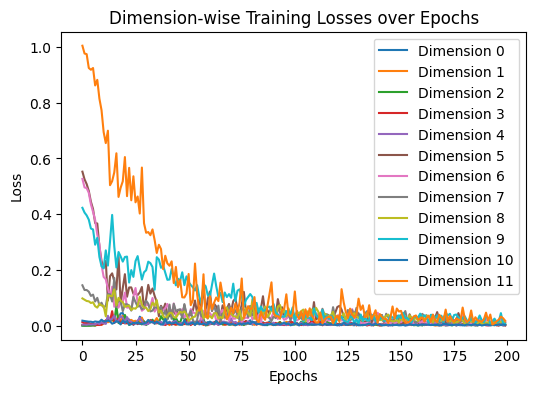

In [11]:
# Visualizing the losses
plt.figure(figsize=(6,4))
for i in range(12):
    plt.plot(feature_losses[f"dim_{i}"], label=f"Dimension {i}")
plt.legend()
plt.title("Dimension-wise Training Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Save the plot with a specific DPI
plt.savefig('pic/training_loss.png', dpi=300)  # 300 DPI is a common high-resolution setting
plt.show()

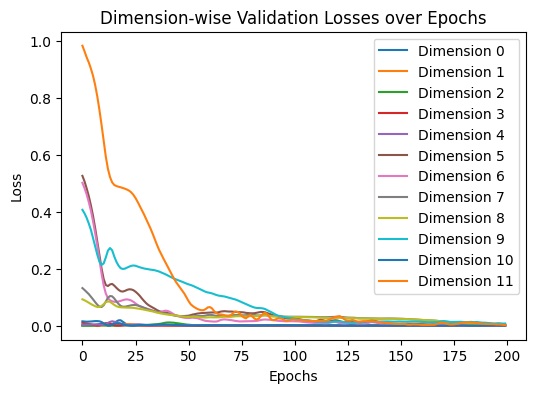

In [12]:
# Visualizing the losses
plt.figure(figsize=(6,4))
for i in range(12):
    plt.plot(val_feature_losses[f"dim_{i}"], label=f"Dimension {i}")
plt.legend()
plt.title("Dimension-wise Validation Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Save the plot with a specific DPI
plt.savefig('pic/val_loss.png', dpi=300)  # 300 DPI is a common high-resolution setting
plt.show()

In [13]:
#test by hand 
test_v = [1000, 0 ]
test_p = [0.5,0.5]
test_behavioral_embedding = behavioral_embedding(test_p, test_v)
test_behavioral_embedding[[0,1,2,3,4,10]] =  test_behavioral_embedding[[0,1,2,3,4,10]]/1000
test_text = option_prompt_generate(test_p, test_v)
print(f"test text : {test_text}")
model_name = 'text-embedding-3-large'
tmp_embeddings = get_embeddings(test_text,model_name)
tmp_text_embeddings = tmp_embeddings.data[0].embedding
tmp_text_embeddings = torch.tensor(tmp_text_embeddings).to(device)
model.eval()
with torch.no_grad():
    tmp_text_shared_embedding = model(tmp_text_embeddings )

test text : 1000 dollars with 50.0 % chance, 0 dollars with 50.0 % chance.


In [14]:
print(f"test behavioral embedding: {test_behavioral_embedding}")
print(f"test text shared embedding: {tmp_text_shared_embedding}")

test behavioral embedding: [1.  0.  0.  0.  1.  0.5 0.5 0.  0.  1.  0.5 1. ]
test text shared embedding: tensor([-0.0084,  0.0031,  0.0081,  0.0019,  0.0142,  0.3999,  0.4673,  0.0188,
         0.0247,  0.7853, -0.0043,  0.7927])
